# [Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf)

[Reference Code](https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/)

In [1]:
import os
import math
import re
from  random import *
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 6GB Laptop GPU'

## 1. Data

### Train, Test, Validation 

In [4]:
import datasets

snli = datasets.load_dataset('snli')

mnli = datasets.load_dataset('glue', 'mnli')
mnli['train'].features,  snli['train'].features

({'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None),
  'idx': Value(dtype='int32', id=None)},
 {'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)})

In [5]:
# List of datasets to remove 'idx' column from
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [6]:
# Remove 'idx' column from each dataset
for column_names in mnli.column_names.keys():
    mnli[column_names] = mnli[column_names].remove_columns('idx')

In [7]:
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [8]:
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([-1,  0,  1,  2]))

In [9]:
# there are -1 values in the label feature, these are where no class could be decided so we remove
snli = snli.filter(lambda x: 0 if x['label'] == -1 else 1)

In [10]:
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([0, 1, 2]))

In [11]:
# Assuming you have your two DatasetDict objects named snli and mnli
from datasets import DatasetDict

# Merge the two DatasetDict objects
raw_dataset = DatasetDict({
    'train': datasets.concatenate_datasets([snli['train'], mnli['train']]).shuffle(seed=55).select(list(range(100_000))),
    'test': datasets.concatenate_datasets([snli['test'], mnli['test_mismatched']]).shuffle(seed=55).select(list(range(10_000))),
    'validation': datasets.concatenate_datasets([snli['validation'], mnli['validation_mismatched']]).shuffle(seed=55).select(list(range(10_000)))
})

#remove .select(list(range(1000))) in order to use full dataset
# Now, merged_dataset_dict contains the combined datasets from snli and mnli
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

## 2. Preprocessing

In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [14]:
def preprocess_function(examples):
    max_seq_length = 128
    padding = 'max_length'
    
    # Tokenize the premise
    premise_result = tokenizer(examples['premise'], padding=padding, max_length=max_seq_length, truncation=True)
    #num_rows, max_seq_length
  
    # Tokenize the hypothesis
    hypothesis_result = tokenizer(examples['hypothesis'], padding=padding, max_length=max_seq_length, truncation=True)
    #num_rows, max_seq_length
   
    # Extract labels
    labels = examples["label"]
    
    #num_rows
    return {
        "premise_input_ids": premise_result["input_ids"],
        "premise_attention_mask": premise_result["attention_mask"],
        "hypothesis_input_ids": hypothesis_result["input_ids"],
        "hypothesis_attention_mask": hypothesis_result["attention_mask"],
        "labels" : labels
    }

tokenized_datasets = raw_dataset.map(preprocess_function,batched=True,)

tokenized_datasets = tokenized_datasets.remove_columns(['premise','hypothesis','label'])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 10000
    })
})

## 3. Data loader

In [16]:
from torch.utils.data import DataLoader

# initialize the dataloader
batch_size = 32
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=batch_size, shuffle=True )
eval_dataloader = DataLoader( tokenized_datasets['validation'],  batch_size=batch_size)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=batch_size)

In [17]:
for batch in train_dataloader:
    print(batch['premise_input_ids'].shape)
    print(batch['premise_attention_mask'].shape)
    print(batch['hypothesis_input_ids'].shape)
    print(batch['hypothesis_attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


## 4. Model

In [18]:
# start from a pretrained bert-base-uncased model
from transformers import BertTokenizer, BertModel
model = BertModel.from_pretrained('bert-base-uncased')

checkpoint = torch.load("bert_model.pth", map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## **Siamese-BERT**

![Siamese BERT](images/Siamese-bert.webp)


### Pooling
SBERT adds a pooling operation to the output of BERT / RoBERTa to derive a fixed sized sentence embedding

In [19]:
#The mean pooling operation is implemented to derive fixed-sized sentence embeddings from the BERT token embeddings
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    
    return pool

## 5. Loss Function

## Classification Objective Function 
We concatenate the sentence embeddings $u$ and $v$ with the element-wise difference  $\lvert u - v \rvert $ and multiply the result with the trainable weight  $ W_t ∈  \mathbb{R}^{3n \times k}  $:

$ o = \text{softmax}\left(W^T \cdot \left(u, v, \lvert u - v \rvert\right)\right) $

where $n$ is the dimension of the sentence embeddings and k the number of labels. We optimize cross-entropy loss. This structure is depicted in Figure 1.

## Regression Objective Function. 
The cosine similarity between the two sentence embeddings $u$ and $v$ is computed (Figure 2). We use means quared-error loss as the objective function.

(Manhatten / Euclidean distance, semantically  similar sentences can be found.)


In [20]:
#The Classification Objective Function (Softmax Loss) is implemented as described in the Sentence-BERT paper:

def configurations(u,v):
    # build the |u-v| tensor
    uv = torch.sub(u, v)   # batch_size, hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim
    
    # concatenate u, v, |u-v|
    x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
    return x

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

In [21]:
classifier_head = torch.nn.Linear(768*3, 3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer_classifier = torch.optim.Adam(classifier_head.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

In [22]:
from transformers import get_linear_schedule_with_warmup

# and setup a warmup for the first ~10% steps
total_steps = int(len(raw_dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,num_training_steps=total_steps - warmup_steps)

# then during the training loop we update the scheduler per step
scheduler.step()

scheduler_classifier = get_linear_schedule_with_warmup(optimizer_classifier, num_warmup_steps=warmup_steps,
                                                       num_training_steps=total_steps - warmup_steps)

# then during the training loop we update the scheduler per step
scheduler_classifier.step()

c:\Users\Mir Ali\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## 6. Training

In [23]:
from tqdm.auto import tqdm

num_epoch = 1   # 1 epoch should be enough, increase if wanted

for epoch in range(num_epoch):
    model.train()  
    classifier_head.train()
   # Initialize the dataloader loop with tqdm for progress tracking
    loop = tqdm(train_dataloader, leave=True)
    
    for step, batch in enumerate(loop):
        # zero all gradients on each new step
        optimizer.zero_grad()
        optimizer_classifier.zero_grad()
        
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        # extract token embeddings from BERT at last_hidden_state
        u = model(inputs_ids_a, attention_mask=attention_a)  
        v = model(inputs_ids_b, attention_mask=attention_b)  

        u_last_hidden_state = u.last_hidden_state # all token embeddings A = batch_size, seq_len, hidden_dim
        v_last_hidden_state = v.last_hidden_state # all token embeddings B = batch_size, seq_len, hidden_dim

         # get the mean pooled vectors
        u_mean_pool = mean_pool(u_last_hidden_state, attention_a) # batch_size, hidden_dim
        v_mean_pool = mean_pool(v_last_hidden_state, attention_b) # batch_size, hidden_dim
        
        # build the |u-v| tensor
        uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
        uv_abs = torch.abs(uv) # batch_size,hidden_dim
        
        # concatenate u, v, |u-v|
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim
        
        # process concatenated tensor through classifier_head
        x = classifier_head(x) #batch_size, classifer
        
        # calculate the 'softmax-loss' between predicted and true label
        loss = criterion(x, label)
        
        # using loss, calculate gradients and then optimizerize
        loss.backward()
        optimizer.step()
        optimizer_classifier.step()

        scheduler.step() # update learning rate scheduler
        scheduler_classifier.step()
        
        # Update tqdm progress bar with loss after each batch
        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())
    
    # Print loss at end of epoch
    print(f'Epoch: {epoch + 1} | loss = {loss.item():.6f}')

  0%|          | 0/3125 [00:00<?, ?it/s]

c:\Users\Mir Ali\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch: 1 | loss = 1.105665


### Saving the Model

In [24]:
torch.save(model.state_dict(), "SBERT_finetuned.pth")
torch.save(classifier_head.state_dict(), "classifier_head.pth")

print("Model saved.")

Model saved.


###  Model Evaluation

In [25]:
model.eval()
classifier_head.eval()

total_similarity = 0
num_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for step, batch in enumerate(eval_dataloader):
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        # extract token embeddings from BERT at last_hidden_state
        u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A = batch_size, seq_len, hidden_dim
        v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B = batch_size, seq_len, hidden_dim

        # get the mean pooled vectors
        u_mean_pool = mean_pool(u, attention_a)  # batch_size, hidden_dim
        v_mean_pool = mean_pool(v, attention_b)  # batch_size, hidden_dim

        
        # build the |u-v| tensor
        uv = torch.sub(u_mean_pool, v_mean_pool)  # batch_size,hidden_dim
        uv_abs = torch.abs(uv)  # batch_size,hidden_dim

        # concatenate u, v, |u-v|
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1)  # batch_size, 3*hidden_dim

        # process concatenated tensor through classifier_head
        logits = classifier_head(x)  # batch_size, classifer

        # get predictions
        preds = torch.argmax(logits, dim=-1)
        
        # Compute cosine similarity
        cosine_sim = F.cosine_similarity(u_mean_pool, v_mean_pool, dim=-1)  # batch_size
        total_similarity += torch.sum(cosine_sim).item()
        num_samples += cosine_sim.shape[0]

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())


# Compute and print average cosine similarity
average_similarity = total_similarity / num_samples
print(f"Average Cosine Similarity: {average_similarity:.4f}")

# Print classification report
class_names = ["entailment", "neutral", "contradiction"]
print(classification_report(all_labels, all_preds, target_names=class_names))

Average Cosine Similarity: 0.7680
               precision    recall  f1-score   support

   entailment       0.35      0.84      0.50      3452
      neutral       0.26      0.01      0.01      3206
contradiction       0.35      0.18      0.24      3342

     accuracy                           0.35     10000
    macro avg       0.32      0.34      0.25     10000
 weighted avg       0.32      0.35      0.26     10000



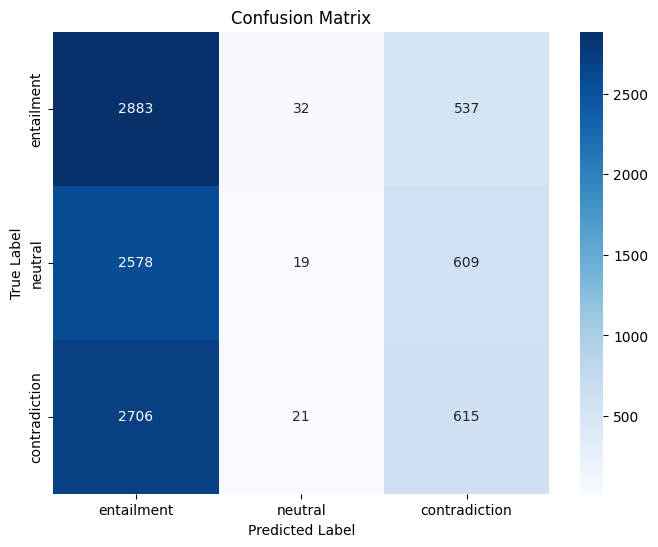

In [26]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


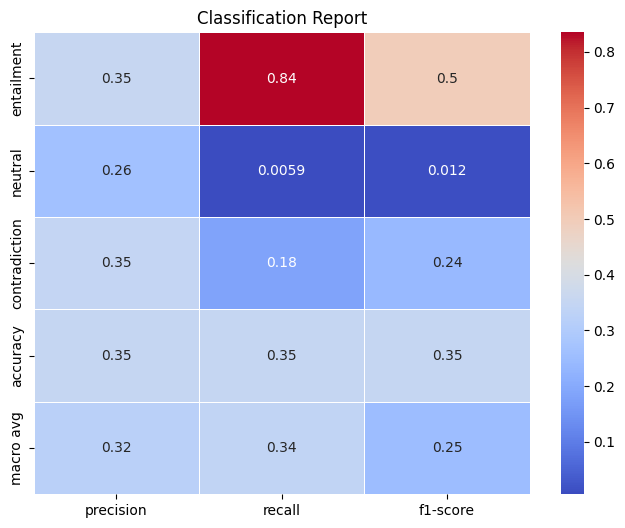

In [ ]:
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).T

# Plot classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Classification Report")
plt.show()

## 7. Inference

In [ ]:
def calculate_similarity(model, tokenizer, sentence_a, sentence_b, device):
    # Tokenize and convert sentences to input IDs and attention masks
    inputs_a = tokenizer(sentence_a, return_tensors='pt', truncation=True, padding=True).to(device)
    inputs_b = tokenizer(sentence_b, return_tensors='pt', truncation=True, padding=True).to(device)

    # Move input IDs and attention masks to the active device
    inputs_ids_a = inputs_a['input_ids']
    attention_a = inputs_a['attention_mask']
    inputs_ids_b = inputs_b['input_ids']
    attention_b = inputs_b['attention_mask']

    # Extract token embeddings from BERT
    u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A = batch_size, seq_len, hidden_dim
    v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B = batch_size, seq_len, hidden_dim

    # Get the mean-pooled vectors
    u = mean_pool(u, attention_a).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim
    v = mean_pool(v, attention_b).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim

    # Calculate cosine similarity
    similarity_score = cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0, 0]

    return similarity_score

# Example usage:
sentence_a = 'Your contribution helped make it possible for us to provide our students with a quality education.'
sentence_b = "Your contributions were of no help with our students' education."
similarity = calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.8057


In [ ]:
sentence_pairs = [
    # Entailment (high similarity)
    ("The quick brown fox jumps over the lazy dog.", "A fast brown fox leaps over a lazy dog."),
    ("She is reading a book in the park.", "She enjoys reading books in the garden."),
    ("The sun rises in the east.", "The sun sets in the west."),
    ("She walked to the store to buy some milk.", "She went to the store to get some milk."),
    
    # Neutral (low similarity)
    ("The car is red.", "The car is parked outside."),
    ("He is wearing a jacket.", "She is walking down the street."),
    ("The sky is cloudy.", "There is a cat sitting on the windowsill."),
    ("She loves playing soccer.", "The table is made of wood."),
    
    # Contradiction (no similarity)
    ("He is playing football in the field.", "She is playing chess at home."),
    ("The dog barked loudly at the mailman.", "The dog is sleeping quietly on the couch."),
    ("I love listening to music on a rainy day.", "I can't stand the sound of music."),
    ("The man is wearing a suit.", "The man is wearing a t-shirt and shorts."),
    ("They are cooking dinner together.", "They are arguing over the TV remote.")
]


# Calculate and display similarity scores
for sentence_a, sentence_b in sentence_pairs:
    similarity_score = calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)
    print(f"Sentence A: {sentence_a}\nSentence B: {sentence_b}\nSimilarity Score: {similarity_score:.4f}\n")

Sentence A: The quick brown fox jumps over the lazy dog.
Sentence B: A fast brown fox leaps over a lazy dog.
Similarity Score: 0.9180

Sentence A: She is reading a book in the park.
Sentence B: She enjoys reading books in the garden.
Similarity Score: 0.8058

Sentence A: The sun rises in the east.
Sentence B: The sun sets in the west.
Similarity Score: 0.9592

Sentence A: She walked to the store to buy some milk.
Sentence B: She went to the store to get some milk.
Similarity Score: 0.9769

Sentence A: The car is red.
Sentence B: The car is parked outside.
Similarity Score: 0.8111

Sentence A: He is wearing a jacket.
Sentence B: She is walking down the street.
Similarity Score: 0.7481

Sentence A: The sky is cloudy.
Sentence B: There is a cat sitting on the windowsill.
Similarity Score: 0.6829

Sentence A: She loves playing soccer.
Sentence B: The table is made of wood.
Similarity Score: 0.4947

Sentence A: He is playing football in the field.
Sentence B: She is playing chess at home.
S

# NLI Text Similarity Classifier

## Overview

This project involves training a BERT-based model for the task of **Natural Language Inference (NLI)**, specifically to classify relationships between sentence pairs. The model was pre-trained on the **BookCorpus** dataset and fine-tuned on **SNLI** and **MNLI** datasets. The goal is to determine whether a pair of sentences is related in the following ways:

- **Entailment**: Sentence B logically follows from Sentence A.
- **Contradiction**: Sentence B contradicts Sentence A.
- **Neutral**: Sentence B is unrelated or doesn't contradict Sentence A.

---

## Table of Contents

1. [Pre-training](#pre-training)
2. [Fine-tuning](#fine-tuning)
3. [Training Parameters](#training-parameters)
4. [Model Architecture](#model-architecture)
5. [Limitations and Improvements](#limitations-and-improvements)

---

## Pre-training

### Dataset

- **Dataset**: BookCorpus
- **Source**: Hugging Face (Community Datasets)
- **Description**: The BookCorpus dataset consists of text extracted from a large collection of books. It is diverse and suitable for learning general language patterns across multiple genres and topics.
- **Total Samples**: 1,000,000
- **Samples Used for Training**: 100,000
- **Columns Used**: Raw text from books (no predefined labels, just plain text).

| **Property**       | **Details**                   |
|-------------------|-------------------------------|
| Dataset Name      | BookCorpus                    |
| Text Used         | Raw text from books           |
| Total Samples    | 1,000,000                      |
| Samples for Training | 100,000                     |

---

### Training Parameters

| **Parameter**         | **Value**               |
|-----------------------|-------------------------|
| Max Sequence Length   | 1000 tokens             |
| Batch Size            | 6                       |
| Number of Epochs      | 1000                    |
| Final Training Loss   | 3.649                   |

---

### Model Architecture

- **Encoder Layers (n_layers)**: 6
- **Multi-Head Attention (n_heads)**: 8
- **Embedding Size (d_model)**: 768
- **Feedforward Dimension (d_ff)**: 3072
- **Key/Value Dimension (d_k, d_v)**: 64
- **Number of Segments (n_segments)**: 2

---

#### Challenges

- **GPU Memory Constraints**: The batch size was limited to 6 due to available GPU memory. Larger batch sizes could improve performance but may cause out-of-memory errors.
- **Overfitting Risk**: With 1000 epochs, the model may have overfitted, especially after a certain number of epochs. Early stopping or regularization techniques could help mitigate this.
- **Handling Long Sequences**: Though the sequence length was limited to 1000 tokens, this may still result in truncation of longer texts.

#### Proposed Improvements

- **Increase Batch Size**: If hardware allows, increasing the batch size could improve performance.
- **Regularization**: Apply dropout or weight decay to reduce overfitting.
- **Learning Rate Schedule**: Implement learning rate warm-ups and schedules for better convergence.

---

## Fine-tuning

### Datasets

- **SNLI** and **MNLI**
- **Source**: Stanford NLP and NYU Machine Learning for Language (Hugging Face)
- **Description**: Both SNLI and MNLI are widely used datasets for Natural Language Inference (NLI) tasks. They consist of sentence pairs and labels indicating the relationship (entailment, contradiction, neutral).

### Merged Dataset

The **SNLI** and **MNLI** datasets were merged to form a larger training set. The training set consists of 100,000 samples, while the validation and test sets consist of 10,000 samples each. 

The merged datasets were shuffled to ensure randomness and to improve generalization during model training. The following dataset splits were created:

- **Train set**: 100,000 samples (merged from SNLI and MNLI train sets)
- **Validation set**: 10,000 samples (merged from SNLI and MNLI validation sets)
- **Test set**: 10,000 samples (merged from SNLI and MNLI test mismatched sets)

| **Dataset**         | **Samples Used for Training** | **Validation Samples** | **Test Samples** |
|---------------------|-------------------------------|------------------------|------------------|
| SNLI + MNLI         | 100,000                       | 10,000                 | 10,000           |

---

### Fine-tuning Parameters

| **Parameter**         | **Value**             |
|-----------------------|-----------------------|
| Max Sequence Length   | 128 tokens            |
| Batch Size            | 32                    |
| Number of Epochs      | 5                     |

---

#### Challenges

- **Memory Limitation**: The batch size was set to 32 to fit within GPU memory limits. Increasing the batch size might speed up training but may lead to memory issues.
- **Overfitting**: With a large number of epochs, the model may overfit on the training set. Monitoring validation loss would be key to prevent this.

#### Proposed Improvements

- **Cross-validation**: Implement cross-validation during fine-tuning to ensure better generalization.
- **Learning Rate Tuning**: Fine-tune the learning rate for better convergence.
- **Regularization**: Apply dropout during fine-tuning to reduce overfitting.

---

## Training Parameters Summary

| **Parameter**         | **Pre-training (BookCorpus)** | **Fine-tuning (SNLI & MNLI)** |
|-----------------------|------------------------------|------------------------------|
| Max Sequence Length   | 1000 tokens                  | 128 tokens                   |
| Batch Size            | 6                            | 32                           |
| Epochs                | 1000                         | 5                            |
| Final Loss            | 3.649                        | -                            |

---

## Model Architecture Summary

| **Architecture Component** | **Value** |
|----------------------------|-----------|
| Encoder Layers (n_layers)  | 6         |
| Attention Heads (n_heads)  | 8         |
| Embedding Size (d_model)   | 768       |
| Feedforward Dimension (d_ff) | 3072    |
| Key/Value Dimensions (d_k, d_v) | 64   |
| Number of Segments (n_segments) | 2   |

---

## Limitations and Challenges

1. **GPU Memory Limitations**: The batch size was constrained by the available GPU memory, which affected training speed.
2. **Overfitting**: With 1000 epochs of pre-training and fine-tuning, there is a risk of overfitting. This could have been mitigated with regularization or early stopping.
3. **Long Sequence Handling**: Although the model can process sequences up to 1000 tokens, longer sequences may result in truncation, losing valuable information.

---

## Proposed Improvements

- **Hardware Upgrade**: Increasing the available GPU memory could allow for larger batch sizes and faster training.
- **Regularization**: Apply dropout or weight decay to prevent overfitting, especially during fine-tuning.
- **Learning Rate Tuning**: Implement a learning rate schedule to improve convergence during training.

---